In [3]:
import os
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.ticker as mticker
warnings.filterwarnings('ignore')
pplt.rc.update({'fontsize':9,'reso':'xx-hi','figure.dpi':100})

In [4]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'test'

In [5]:
with xr.open_dataset(f'{SPLITSDIR}/{SPLIT}.h5', engine='h5netcdf') as ds:
    lev = ds['lev'].load()

results = {}
for model in MODELS:
    name = model['name']
    if 'kernel' not in name:
        continue
    filepath = os.path.join(WEIGHTSDIR,f'{name}_{SPLIT}_weights.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath,engine='h5netcdf') as ds:
        if ('k1' in ds) and ('k2' in ds):
            k1,k2 = ds['k1'].load(),ds['k2'].load()
            k1mean,k2mean = k1.mean('seed'),k2.mean('seed')
            k1std,k2std   = k1.std('seed'),k2.std('seed')
            results[name] = dict(kind='mixture',mean1=k1mean,std1=k1std,mean2=k2mean,std2=k2std)
        else:
            k     = ds['k'].load()
            kmean = k.mean('seed')
            kstd  = k.std('seed')
            results[name] = dict(kind='single',mean=kmean,std=kstd)

print(f'Found {len(results)} kernel models with saved weights!')

Found 6 kernel models with saved weights!


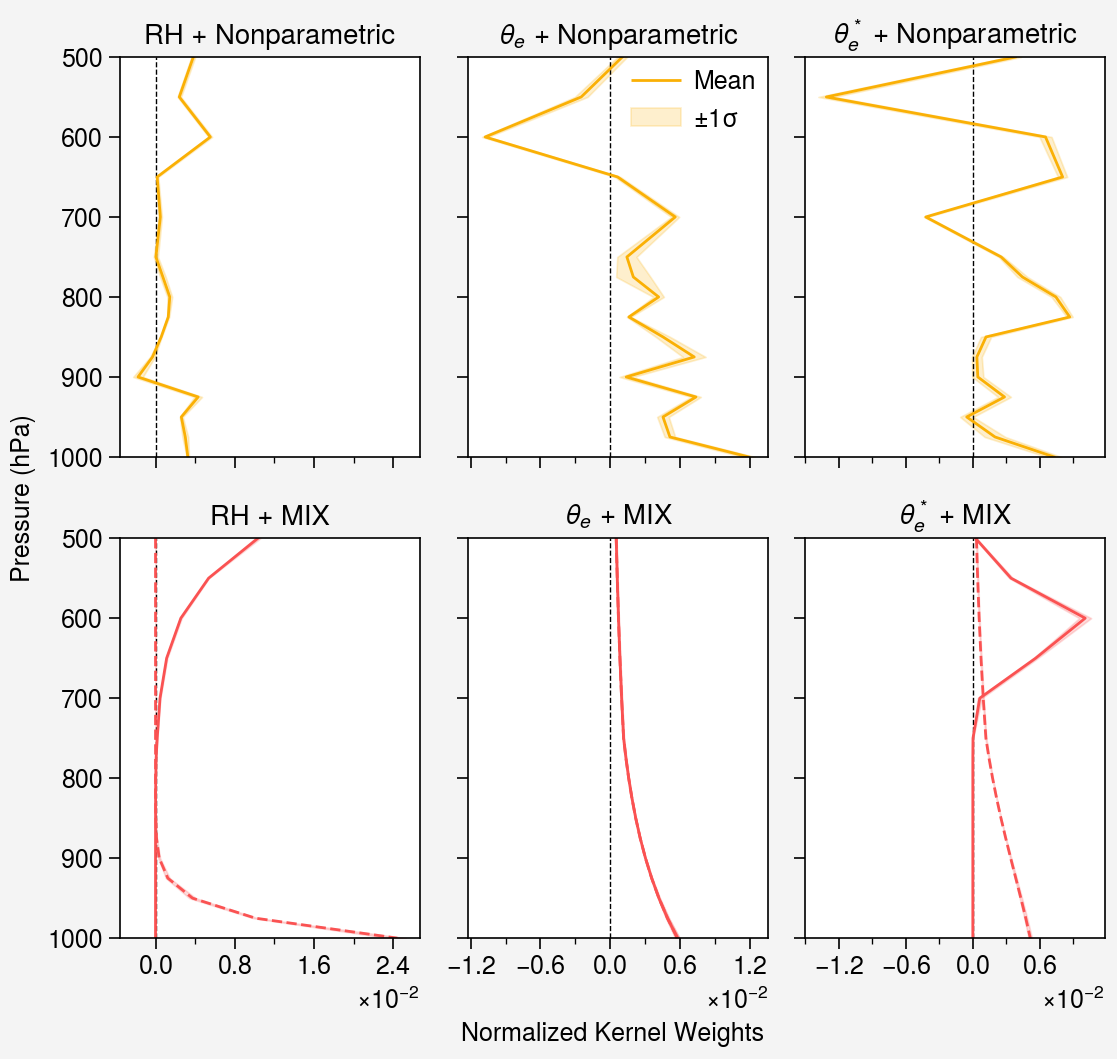

In [10]:
families   = [('nonparametric','Nonparametric'),
              ('mixparametric','MIX')]
familylabels = [title for _,title in families]
varlabels    = ['RH',r'$\mathit{\theta_e}$',r'$\mathit{\theta_e^*}$']
nrows,ncols  = len(families),3

fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,refheight=2,sharex=True,sharey=True)
axs.format(grid=False,ylabel='Pressure (hPa)',yreverse=True,yminorticks='none')

colmin = [np.inf]*ncols
colmax = [-np.inf]*ncols
for row,(family,title) in enumerate(families):
    name  = next((nm for nm in results if family in nm),None)
    entry = results[name]
    color = 'yellow6' if ('nonparametric' in name) else 'red6'
    for col in range(ncols):
        ax = axs[row,col]
        ax.format(title=f'{varlabels[col]} + {familylabels[row]}')
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
        if entry['kind']=='mixture':
            mean1,std1 = entry['mean1'].isel(field=col),entry['std1'].isel(field=col)
            mean2,std2 = entry['mean2'].isel(field=col),entry['std2'].isel(field=col)
            ax.plot(mean1,lev,color=color,linewidth=1,label='Component 1')
            ax.plot(mean2,lev,color=color,linewidth=1,linestyle='--',label='Component 2')
            ax.fill_betweenx(lev,mean1-std1,mean1+std1,color=color,alpha=0.2)
            ax.fill_betweenx(lev,mean2-std2,mean2+std2,color=color,alpha=0.2)
            values = [mean1.values,mean2.values,
                      (mean1-std1).values,(mean1+std1).values,
                      (mean2-std2).values,(mean2+std2).values]
        else:
            mean,std = entry['mean'].isel(field=col),entry['std'].isel(field=col)
            ax.plot(mean,lev,color=color,linewidth=1,label='Mean')
            ax.fill_betweenx(lev,mean-std,mean+std,color=color,alpha=0.2,label=r'$\pm 1\sigma$')
            values = [mean.values,(mean-std).values,(mean+std).values]
            if row==0 and col==1:
                ax.legend(loc='ur',ncols=1,frame=False)
        vmin = min(float(np.nanmin(v)) for v in values)
        vmax = max(float(np.nanmax(v)) for v in values)
        colmin[col] = min(colmin[col],vmin)
        colmax[col] = max(colmax[col],vmax)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        if row == nrows-1:
            ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
            ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,2))
        else:
            ax.format(xticklabels=[])
for col in range(ncols):
    xmin,xmax = colmin[col],colmax[col]
    span = max(xmax-xmin,1e-12)
    pad  = 0.05*span
    axs[:,col].format(xlim=(xmin-pad,xmax+pad),xreverse=False)
fig.format(xlabel='Normalized Kernel Weights',xlabelpad=15)
pplt.show()
fig.save('../figs/weightsbest.png')

In [13]:
# families   = [('nonparametric','Nonparametric'),
#               ('gaussian','Gaussian'),
#               ('mixgaussian','Mixture-of-Gaussians'),
#               ('mixparametric','MIX'),
#               ('exponential','Exponential'),
#               ('tophat','Top-Hat')]

# familylabels = [title for _,title in families]
# varlabels    = ['RH',r'$\mathit{\theta_e}$',r'$\mathit{\theta_e^*}$']
# nrows,ncols  = len(families),3

# fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,refheight=2,sharex=True,sharey=True)
# axs.format(grid=False,ylabel='Pressure (hPa)',yreverse=True,yminorticks='none')
# colmin = [np.inf]*ncols
# colmax = [-np.inf]*ncols
# for row,(family,title) in enumerate(families):
#     name  = next((nm for nm in results if family in nm),None)
#     entry = results[name]
#     color = 'yellow6' if ('nonparametric' in name) else 'red6'
#     for col in range(ncols):
#         ax = axs[row,col]
#         ax.format(title=f'{varlabels[col]} + {familylabels[row]}')
#         ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
#         if entry['kind']=='mixture':
#             mean1,std1 = entry['mean1'].isel(field=col),entry['std1'].isel(field=col)
#             mean2,std2 = entry['mean2'].isel(field=col),entry['std2'].isel(field=col)
#             ax.plot(mean1,lev,color=color,linewidth=1,label='Component 1')
#             ax.plot(mean2,lev,color=color,linewidth=1,linestyle='--',label='Component 2')
#             ax.fill_betweenx(lev,mean1-std1,mean1+std1,color=color,alpha=0.2)
#             ax.fill_betweenx(lev,mean2-std2,mean2+std2,color=color,alpha=0.2)
#             values = [mean1.values,mean2.values,
#                       (mean1-std1).values,(mean1+std1).values,
#                       (mean2-std2).values,(mean2+std2).values]
#         else:
#             mean,std = entry['mean'].isel(field=col),entry['std'].isel(field=col)
#             ax.plot(mean,lev,color=color,linewidth=1,label='Mean')
#             ax.fill_betweenx(lev,mean-std,mean+std,color=color,alpha=0.2,label=r'$\pm 1\sigma$')
#             values = [mean.values,(mean-std).values,(mean+std).values]
#             if row==0 and col==1:
#                 ax.legend(loc='ur',ncols=1,frame=False)
#         vmin = min(float(np.nanmin(v)) for v in values)
#         vmax = max(float(np.nanmax(v)) for v in values)
#         colmin[col] = min(colmin[col],vmin)
#         colmax[col] = max(colmax[col],vmax)
#         ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
#         ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
#         if row == nrows-1:
#             ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
#             ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,2))
#         else:
#             ax.format(xticklabels=[])
# for col in range(ncols):
#     xmin,xmax = colmin[col],colmax[col]
#     span = max(xmax-xmin,1e-12)
#     pad  = 0.05*span
#     axs[:,col].format(xlim=(xmin-pad,xmax+pad),xreverse=False)
# fig.format(xlabel='Normalized Kernel Weights',xlabelpad=15)
# pplt.show()
# fig.save('../figs/weightsfull.png')

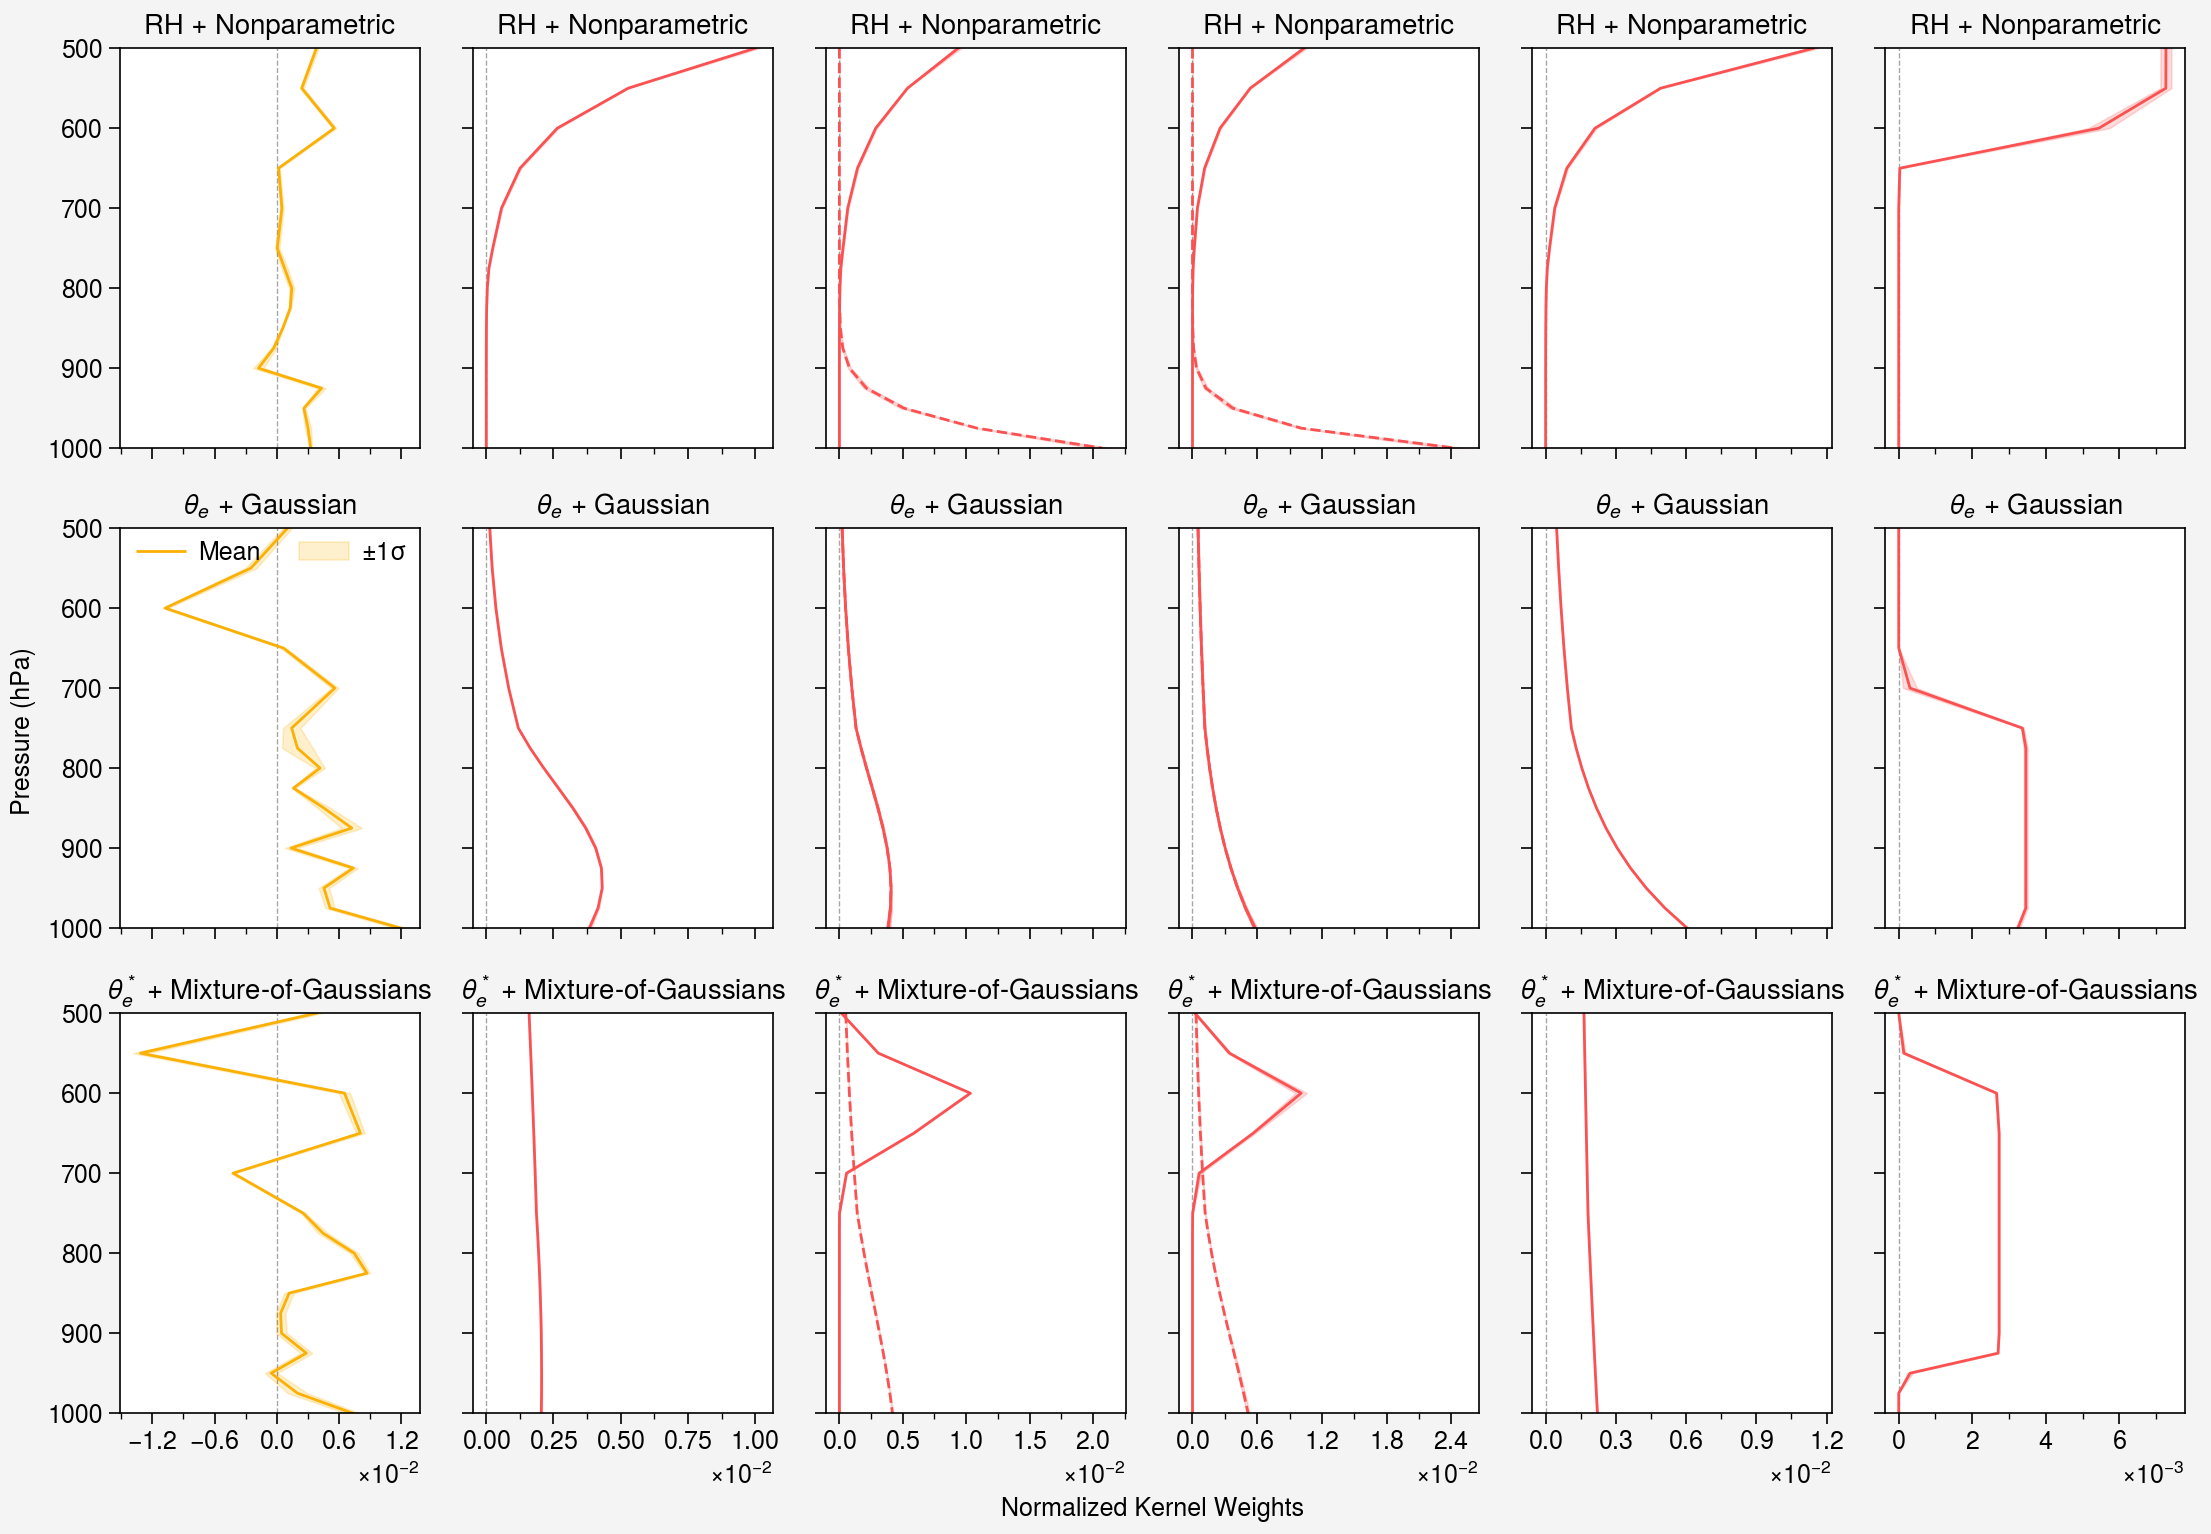

In [20]:
families = [
    ('nonparametric','Nonparametric'),
    ('gaussian','Gaussian'),
    ('mixgaussian','Mixture-of-Gaussians'),
    ('mixparametric','MIX'),
    ('exponential','Exponential'),
    ('tophat','Top-Hat'),]

familylabels = [title for _,title in families]
varlabels    = ['RH', r'$\mathit{\theta_e}$', r'$\mathit{\theta_e^*}$']
nrows,ncols  = len(varlabels),len(families)

fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,refheight=2,sharex=True,sharey=True)
axs.format(grid=False,ylabel='Pressure (hPa)',yreverse=True,yminorticks='none')
colmin = [np.inf]*ncols
colmax = [-np.inf]*ncols
for col,(family,title) in enumerate(families):
    name  = next((nm for nm in results if family in nm),None)
    entry = results[name]
    color = 'yellow6' if ('nonparametric' in name) else 'red6'
    for row in range(nrows):
        ax = axs[row,col]
        ax.format(title=f'{varlabels[row]} + {familylabels[row]}')
        ax.axvline(0,color='k',linewidth=0.5,linestyle='--',alpha=0.35)
        if entry['kind']=='mixture':
            mean1,std1 = entry['mean1'].isel(field=row),entry['std1'].isel(field=row)
            mean2,std2 = entry['mean2'].isel(field=row),entry['std2'].isel(field=row)
            ax.plot(mean1,lev,color=color,linewidth=1,label='Component 1')
            ax.plot(mean2,lev,color=color,linewidth=1,linestyle='--',label='Component 2')
            ax.fill_betweenx(lev,mean1-std1,mean1+std1,color=color,alpha=0.2)
            ax.fill_betweenx(lev,mean2-std2,mean2+std2,color=color,alpha=0.2)
            values = [mean1.values,mean2.values,
                      (mean1-std1).values,(mean1+std1).values,
                      (mean2-std2).values,(mean2+std2).values]
        else:
            mean,std = entry['mean'].isel(field=row),entry['std'].isel(field=row)
            ax.plot(mean,lev,color=color,linewidth=1,label='Mean')
            ax.fill_betweenx(lev,mean-std,mean+std,color=color, alpha=0.2,label=r'$\pm 1\sigma$')
            values = [mean.values,(mean-std).values,(mean+std).values]
            if row==1 and col==0:
                ax.legend(loc='ur',frame=False)
        vmin = min(float(np.nanmin(v)) for v in values)
        vmax = max(float(np.nanmax(v)) for v in values)
        colmin[col] = min(colmin[col],vmin)
        colmax[col] = max(colmax[col],vmax)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        if row == nrows - 1:
            ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
            ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,2))
        else:
            ax.format(xticklabels=[])
for col in range(ncols):
    xmin, xmax = colmin[col],colmax[col]
    span = max(xmax-xmin,1e-12)
    pad  = 0.05*span
    axs[:,col].format(xlim=(xmin-pad,xmax+pad),xreverse=False)
fig.format(xlabel='Normalized Kernel Weights',xlabelpad=15)
pplt.show()
fig.save('../figs/weightsfull.png', dpi=300)